In [1]:
%matplotlib inline

D:\Anaconda\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.optim as optim
import gc

# from sklearn import svm, decomposition
from preprocess import remove_high_freq, whitening, from_cifar_to_np, from_submit_to_np
from plot import imshow
from util import trainNN, cal_accuracy, cal_class_accuracy, get_submit_result, export_to_file, print_accracy
from models import *

use_pca = False
use_forieum = False
export_csv = True
csv_name = 'res_resnet.csv'
BATCH_SIZE = 32

In [3]:
print('==> Preparing data..')
transform_train = transforms.Compose(
    [
#          transforms.RandomRotation(5),
         transforms.RandomCrop(32, padding=4),
#          transforms.RandomResizedCrop(32),
         transforms.RandomHorizontalFlip(),
#          transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
         transforms.ToTensor(),
         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
         remove_high_freq
    ]) if use_forieum else transforms.Compose(
    [
#          transforms.RandomRotation(5),
         transforms.RandomCrop(32, padding=4),
#          transforms.RandomResizedCrop(32),
         transforms.RandomHorizontalFlip(),
#          transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
         transforms.ToTensor(),
         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ]) 

transform_test = transforms.Compose(
    [
         transforms.ToTensor(),
         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
         remove_high_freq
    ]) if use_forieum else transforms.Compose(
    [
         transforms.ToTensor(),
         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]) 


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=0)
submitset = np.load("./test/y_test.npy")

submit_images = [ transform_test(img) for img in submitset]

submitloader = torch.utils.data.DataLoader(submit_images, batch_size=2,
                                          shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [4]:
trainX, trainY = from_cifar_to_np(trainloader)
if not use_forieum:
    trainX = np.reshape(trainX, (50000, 3072))
print(trainX.shape)
print(trainY.shape)

(50000, 3072)
(50000,)


In [5]:
testX, testY = from_cifar_to_np(testloader)
if not use_forieum:
    testX = np.reshape(testX, (10000, 3072))
print(testX.shape)
print(testY.shape)

(10000, 3072)
(10000,)


In [6]:
submitX = from_submit_to_np(submitloader)
if not use_forieum:
    submitX = np.reshape(submitX, (12000, 3072))
print(submitX.shape)

(12000, 3072)


In [7]:
# Assume that we are on a CUDA machine, then this should print a CUDA device:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


torch.Size([128, 3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 deer  frog  bird  ship   dog   dog horse  deer


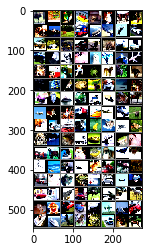

In [8]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# print(images)
print(images.size())

# show images in a batch, which contains 8 images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

In [10]:
print('==> Building model..')
# net = SeventySevenNet()
net = ResNet18()
# net = LargeNet()
# net = VGG('VGG19')
net = net.to(device)
criterion = nn.CrossEntropyLoss()

==> Building model..


In [11]:
for i in range(17): 
    optimizer = optim.SGD(net.parameters(), lr=1e-1, momentum=0.9, weight_decay=5e-4)
    trainNN(net, trainloader, optimizer, criterion,  5)
    print('Accuracy of the network on the 10000 test images: %f %%' % (
        100 * cal_accuracy(net, testloader)))
    print('Accuracy of the network on the train images: %f %%' % (
        100 * cal_accuracy(net, trainloader)))

Training starts
[1,   100] double loss: 0.0183572
[1,   200] double loss: 0.0143085
[1,   300] double loss: 0.0131257
[2,   100] double loss: 0.0118397
[2,   200] double loss: 0.0113356
[2,   300] double loss: 0.0105076
[3,   100] double loss: 0.0095324
[3,   200] double loss: 0.0088458
[3,   300] double loss: 0.0085841
[4,   100] double loss: 0.0076146
[4,   200] double loss: 0.0073092
[4,   300] double loss: 0.0071013
[5,   100] double loss: 0.0064105
[5,   200] double loss: 0.0064299
[5,   300] double loss: 0.0060497
Accuracy of the network on the 10000 test images: 70.960000 %
Accuracy of the network on the train images: 73.852000 %
Training starts
[1,   100] double loss: 0.0056182
[1,   200] double loss: 0.0055049
[1,   300] double loss: 0.0052741
[2,   100] double loss: 0.0049253
[2,   200] double loss: 0.0049275
[2,   300] double loss: 0.0047652
[3,   100] double loss: 0.0045623
[3,   200] double loss: 0.0045715
[3,   300] double loss: 0.0044174
[4,   100] double loss: 0.0042450

In [12]:
for i in range(11): 
    optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9, weight_decay=5e-4)
    trainNN(net, trainloader, optimizer, criterion,  5)
    print('Accuracy of the network on the 10000 test images: %f %%' % (
        100 * cal_accuracy(net, testloader)))
    print('Accuracy of the network on the train images: %f %%' % (
        100 * cal_accuracy(net, trainloader)))

Training starts
[1,   100] double loss: 0.0016069
[1,   200] double loss: 0.0012455
[1,   300] double loss: 0.0011470
[2,   100] double loss: 0.0009283
[2,   200] double loss: 0.0009418
[2,   300] double loss: 0.0008954
[3,   100] double loss: 0.0007873
[3,   200] double loss: 0.0007215
[3,   300] double loss: 0.0007336
[4,   100] double loss: 0.0006879
[4,   200] double loss: 0.0006745
[4,   300] double loss: 0.0006250
[5,   100] double loss: 0.0005940
[5,   200] double loss: 0.0005805
[5,   300] double loss: 0.0005828
Accuracy of the network on the 10000 test images: 91.860000 %
Accuracy of the network on the train images: 97.946000 %
Training starts
[1,   100] double loss: 0.0005167
[1,   200] double loss: 0.0004872
[1,   300] double loss: 0.0005294
[2,   100] double loss: 0.0004792
[2,   200] double loss: 0.0004557
[2,   300] double loss: 0.0004990
[3,   100] double loss: 0.0004215
[3,   200] double loss: 0.0004076
[3,   300] double loss: 0.0003936
[4,   100] double loss: 0.0003208

In [13]:
for i in range(11): 
    optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-3)
    trainNN(net, trainloader, optimizer, criterion,  5)
    print('Accuracy of the network on the 10000 test images: %f %%' % (
        100 * cal_accuracy(net, testloader)))
    print('Accuracy of the network on the train images: %f %%' % (
        100 * cal_accuracy(net, trainloader)))

Training starts
[1,   100] double loss: 0.0002244
[1,   200] double loss: 0.0001556
[1,   300] double loss: 0.0001417
[2,   100] double loss: 0.0001203
[2,   200] double loss: 0.0001010
[2,   300] double loss: 0.0000947
[3,   100] double loss: 0.0000888
[3,   200] double loss: 0.0000847
[3,   300] double loss: 0.0000925
[4,   100] double loss: 0.0000840
[4,   200] double loss: 0.0000840
[4,   300] double loss: 0.0000847
[5,   100] double loss: 0.0000764
[5,   200] double loss: 0.0000913
[5,   300] double loss: 0.0000786
Accuracy of the network on the 10000 test images: 93.090000 %
Accuracy of the network on the train images: 99.892000 %
Training starts
[1,   100] double loss: 0.0000786
[1,   200] double loss: 0.0000796
[1,   300] double loss: 0.0000894
[2,   100] double loss: 0.0000776
[2,   200] double loss: 0.0000793
[2,   300] double loss: 0.0000768
[3,   100] double loss: 0.0000796
[3,   200] double loss: 0.0000855
[3,   300] double loss: 0.0000821
[4,   100] double loss: 0.0000832

In [14]:
for i in range(3): 
    optimizer = optim.SGD(net.parameters(), lr=1e-4, momentum=0.9, weight_decay=5e-3)
    trainNN(net, trainloader, optimizer, criterion,  5)
    print('Accuracy of the network on the 10000 test images: %f %%' % (
        100 * cal_accuracy(net, testloader)))
    print('Accuracy of the network on the train images: %f %%' % (
        100 * cal_accuracy(net, trainloader)))

Training starts
[1,   100] double loss: 0.0001849
[1,   200] double loss: 0.0001603
[1,   300] double loss: 0.0001527
[2,   100] double loss: 0.0001450
[2,   200] double loss: 0.0001423
[2,   300] double loss: 0.0001386
[3,   100] double loss: 0.0001366
[3,   200] double loss: 0.0001331
[3,   300] double loss: 0.0001340
[4,   100] double loss: 0.0001302
[4,   200] double loss: 0.0001289
[4,   300] double loss: 0.0001295
[5,   100] double loss: 0.0001270
[5,   200] double loss: 0.0001264
[5,   300] double loss: 0.0001258
Accuracy of the network on the 10000 test images: 92.380000 %
Accuracy of the network on the train images: 99.968000 %
Training starts
[1,   100] double loss: 0.0001276
[1,   200] double loss: 0.0001238
[1,   300] double loss: 0.0001277
[2,   100] double loss: 0.0001233
[2,   200] double loss: 0.0001232
[2,   300] double loss: 0.0001240
[3,   100] double loss: 0.0001173
[3,   200] double loss: 0.0001176
[3,   300] double loss: 0.0001192
[4,   100] double loss: 0.0001187

In [15]:
params = list(net.parameters())
print(len(params))

62


In [16]:
cal_class_accuracy(net, testloader)

Accuracy of plane : 95 %
Accuracy of   car : 96 %
Accuracy of  bird : 89 %
Accuracy of   cat : 83 %
Accuracy of  deer : 91 %
Accuracy of   dog : 96 %
Accuracy of  frog : 94 %
Accuracy of horse : 93 %
Accuracy of  ship : 97 %
Accuracy of truck : 96 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


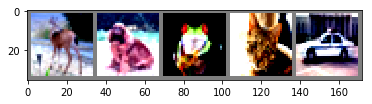

In [9]:
images = submit_images[2100:2105]
imshow(torchvision.utils.make_grid(images))

(2, 3, 32, 32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


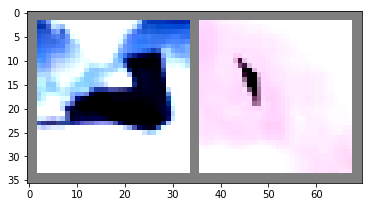

In [10]:
dataiter = iter(submitloader)
images = dataiter.next()
print(np.array(images).shape)
imshow(torchvision.utils.make_grid(images))

In [19]:
gc.collect()

2366

In [20]:
# res_labels = get_submit_result(net, submitloader)
res_per = []
with torch.no_grad():
    for i, data in enumerate(submitloader, 0):
        inputs = data.to(device)
        # forward + backward + optimize
        outputs = net(inputs)
        for o in outputs:
            res_per.append(o)
res_labels = [int(torch.max(t,0)[1]) for t in res_per]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 deer   dog  frog   cat   car   cat   cat  frog  ship horse  deer plane truck  bird   car   cat plane  deer  frog horse


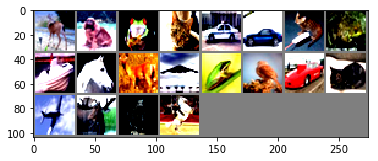

In [21]:
images = submit_images[2100:2120]
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[res_labels[j]] for j in range(2100,2120)))

In [22]:
if export_csv:
    export_to_file(csv_name, res_labels)

In [23]:
net = SeventySevenNet()
# net = LargeNet()
# net = VGG('VGG19')
net = net.to(device)
criterion = nn.CrossEntropyLoss()

In [ ]:
for i in range(17): 
    optimizer = optim.SGD(net.parameters(), lr=1e-1, momentum=0.9, weight_decay=2e-2)
    trainNN(net, trainloader, optimizer, criterion,  5)
    print('Accuracy of the network on the 10000 test images: %f %%' % (
        100 * cal_accuracy(net, testloader)))
    print('Accuracy of the network on the train images: %f %%' % (
        100 * cal_accuracy(net, trainloader)))

Training starts
[1,   100] double loss: 0.0160670
[1,   200] double loss: 0.0154427
[1,   300] double loss: 0.0160660
[2,   100] double loss: 0.0156977
[2,   200] double loss: 0.0157500
[2,   300] double loss: 0.0159635
[3,   100] double loss: 0.0157508
[3,   200] double loss: 0.0155613
[3,   300] double loss: 0.0156615
[4,   100] double loss: 0.0154169
[4,   200] double loss: 0.0152055
[4,   300] double loss: 0.0152563
[5,   100] double loss: 0.0148933
[5,   200] double loss: 0.0151202
[5,   300] double loss: nan
Accuracy of the network on the 10000 test images: 10.000000 %
Accuracy of the network on the train images: 10.000000 %
Training starts
[1,   100] double loss: nan
[1,   200] double loss: nan
[1,   300] double loss: nan
[2,   100] double loss: nan
[2,   200] double loss: nan
[2,   300] double loss: nan
[3,   100] double loss: nan
[3,   200] double loss: nan
[3,   300] double loss: nan
[4,   100] double loss: nan
[4,   200] double loss: nan
[4,   300] double loss: nan
[5,   100

In [ ]:
for i in range(11): 
    optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9, weight_decay=2e-2)
    trainNN(net, trainloader, optimizer, criterion,  5)
    print('Accuracy of the network on the 10000 test images: %f %%' % (
        100 * cal_accuracy(net, testloader)))
    print('Accuracy of the network on the train images: %f %%' % (
        100 * cal_accuracy(net, trainloader)))

In [ ]:
for i in range(11): 
    optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9, weight_decay=3e-2)
    trainNN(net, trainloader, optimizer, criterion,  5)
    print('Accuracy of the network on the 10000 test images: %f %%' % (
        100 * cal_accuracy(net, testloader)))
    print('Accuracy of the network on the train images: %f %%' % (
        100 * cal_accuracy(net, trainloader)))

In [ ]:
for i in range(3): 
    optimizer = optim.SGD(net.parameters(), lr=1e-4, momentum=0.9, weight_decay=3e-2)
    trainNN(net, trainloader, optimizer, criterion,  5)
    print('Accuracy of the network on the 10000 test images: %f %%' % (
        100 * cal_accuracy(net, testloader)))
    print('Accuracy of the network on the train images: %f %%' % (
        100 * cal_accuracy(net, trainloader)))

In [ ]:
params = list(net.parameters())
print(len(params))

In [ ]:
cal_class_accuracy(net, testloader)

In [ ]:
images = submit_images[2100:2105]
imshow(torchvision.utils.make_grid(images))

In [ ]:
dataiter = iter(submitloader)
images = dataiter.next()
print(np.array(images).shape)
imshow(torchvision.utils.make_grid(images))

In [ ]:
res_per = []
with torch.no_grad():
    for i, data in enumerate(submitloader, 0):
        inputs = data.to(device)
        # forward + backward + optimize
        outputs = net(inputs)
        for o in outputs:
            res_per.append(o)
res_labels = [int(torch.max(t,0)[1]) for t in res_per]

In [ ]:
images = submit_images[2100:2120]
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[res_labels[j]] for j in range(2100,2120)))

In [ ]:
if export_csv:
    export_to_file('res_seventyseven_200_epoch.csv', res_labels)